In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
#Metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras.layers import Input


In [ ]:
data= pd.read_excel('/content/database_non-shows (2) (3).xlsx')

In [ ]:
data['Appointment Type'].value_counts()

,count
Appointment Type,
1,12153
0,6434


In [ ]:
Labels = data['Appointment Type'].values
Features = data.drop(['Appointment Type'],axis=1).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.2, stratify=Labels, random_state=42)

print('Train data shape:', X_train.shape)
print('Train labels shape:', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Train data shape: (14869, 12)
Train labels shape: (14869,)
Test data shape: (3718, 12)
Test labels shape: (3718,)


In [ ]:
y_train= tf.keras.utils.to_categorical(
    y_train, num_classes=2
)

In [ ]:
y_test= tf.keras.utils.to_categorical(
    y_test, num_classes=2
)

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train=np.expand_dims(X_train, axis=-1)
X_test=np.expand_dims(X_test, axis=-1)

In [ ]:
X_train.shape

(14869, 12, 1)

In [ ]:
def evaluate_model(model, X_test, y_test, history):

    # Realizar predicciones con el modelo
    y_pred = model.predict(X_test)

    # Obtener la clase con la máxima probabilidad en las etiquetas verdaderas (y_test)
    max_prob_true = np.argmax(y_test, axis=1)

    # Obtener la clase con la máxima probabilidad en las predicciones (predict)
    max_prob_pred = np.argmax(y_pred, axis=1)

    # Calcular las métricas
    accuracy = accuracy_score(max_prob_true, max_prob_pred)
    f1 = f1_score(max_prob_true, max_prob_pred)
    recall = recall_score(max_prob_true, max_prob_pred)

    # Mostrar las métricas
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Recall:", recall)

    # Graficar la precisión para entrenamiento y validación
    plt.plot(history.history['accuracy'], label='Train Accuracy')  # Precisión del entrenamiento
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')  # Precisión de la validación
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Graficar la pérdida para entrenamiento y validación
    plt.plot(history.history['loss'], label='Train Loss')  # Pérdida del entrenamiento
    plt.plot(history.history['val_loss'], label='Test Loss')  # Pérdida de la validación
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(max_prob_true, max_prob_pred)

    # Graficar la matriz de confusión usando seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

     # Binarizar las etiquetas verdaderas para ROC multi-clase
    y_test_bin = label_binarize(y_test, classes=np.arange(y_pred.shape[1]))

    # Número de clases
    n_classes = y_pred.shape[1]

    # Inicializar las variables para la curva ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcular fpr, tpr y AUC para cada clase
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Gráfica ROC para cada clase
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Agregar la línea de referencia
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

    # Etiquetas y título del gráfico
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

#CNN Simple

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# ANN
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 36s 224ms/step - accuracy: 0.5337 - loss: 1.2892 - val_accuracy: 0.6538 - val_loss: 0.6954
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5945 - loss: 0.7396 - val_accuracy: 0.6538 - val_loss: 0.6978
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6184 - loss: 0.6882 - val_accuracy: 0.6538 - val_loss: 0.6649
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6212 - loss: 0.6698 - val_accuracy: 0.6538 - val_loss: 0.6590
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6339 - loss: 0.6653 - val_accuracy: 0.6538 - val_loss: 0.6445
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6386 - loss: 0.6573 - val_accuracy: 0.6538 - val_loss: 0.6316
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6571 - loss: 0.6373 - val_accuracy: 0.6538 - val_loss: 0.5993
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6434 - loss: 0.6330 - val_a

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7816030123722432
F1 Score: 0.8403460479748328
Recall: 0.879062114356232


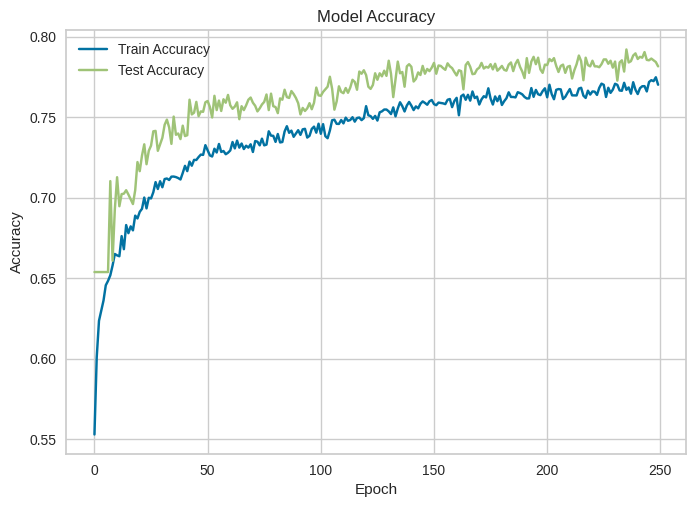

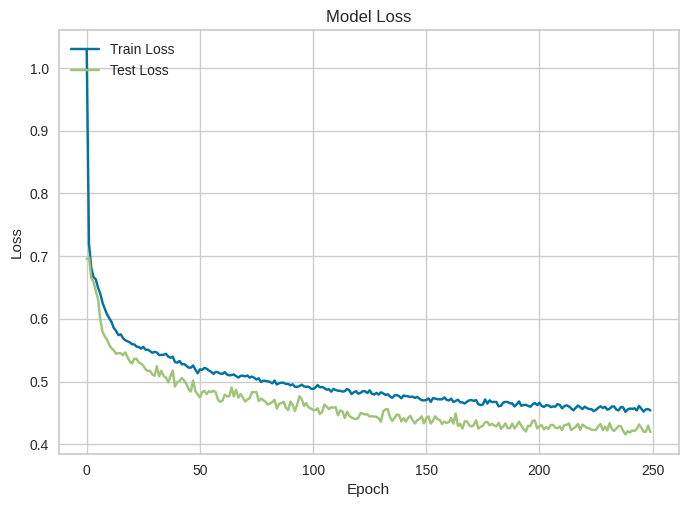

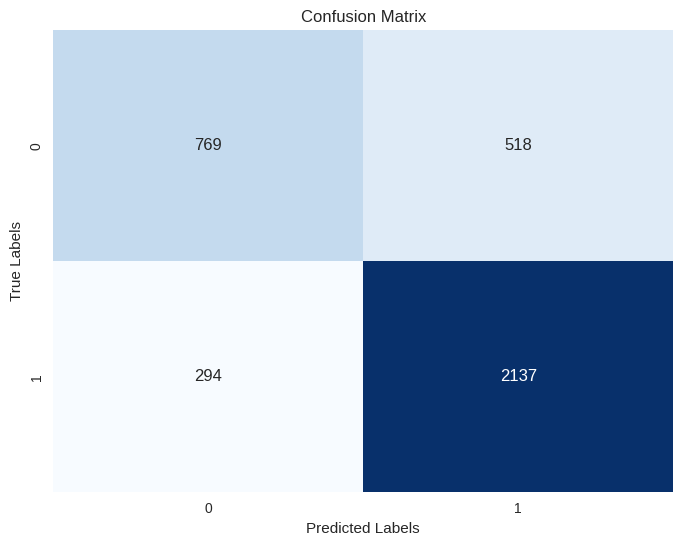

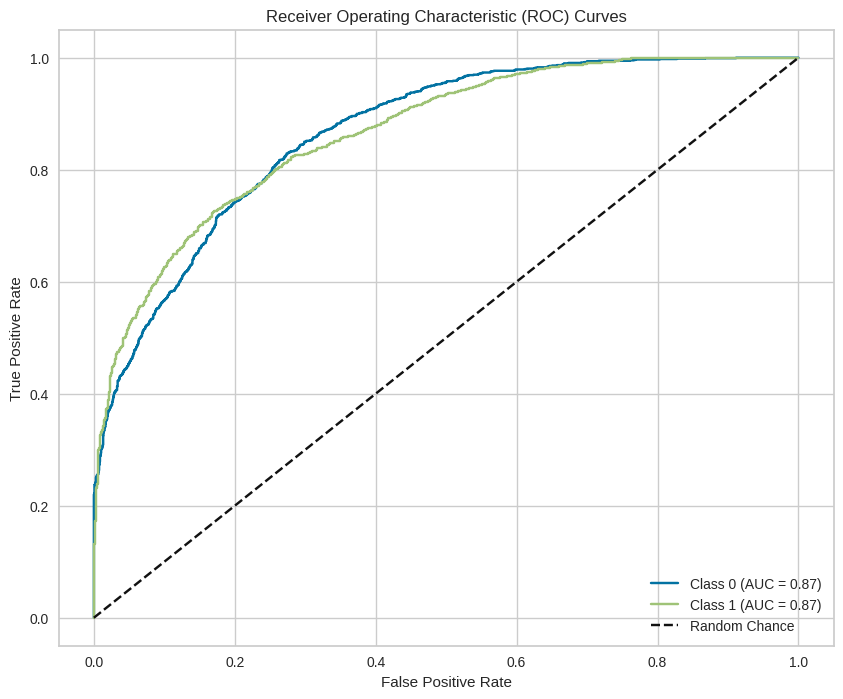

In [ ]:
evaluate_model(model, X_test, y_test, history)

##CNN 2: Una capa mas

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

#Capa 1
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

#Capa 2
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

x = tf.keras.layers.Flatten()(x)

# ANN
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 31s 163ms/step - accuracy: 0.5337 - loss: 1.4007 - val_accuracy: 0.6525 - val_loss: 0.6485
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5763 - loss: 0.8347 - val_accuracy: 0.6538 - val_loss: 0.6495
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6016 - loss: 0.7229 - val_accuracy: 0.6538 - val_loss: 0.6551
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6238 - loss: 0.6868 - val_accuracy: 0.6538 - val_loss: 0.6608
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6293 - loss: 0.6726 - val_accuracy: 0.6538 - val_loss: 0.6522
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6379 - loss: 0.6609 - val_accuracy: 0.6538 - val_loss: 0.6450
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6397 - loss: 0.6600 - val_accuracy: 0.6538 - val_loss: 0.6481
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6360 - loss: 0.6623 - val_

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7778375470683163
F1 Score: 0.8399224806201551
Recall: 0.8914027149321267


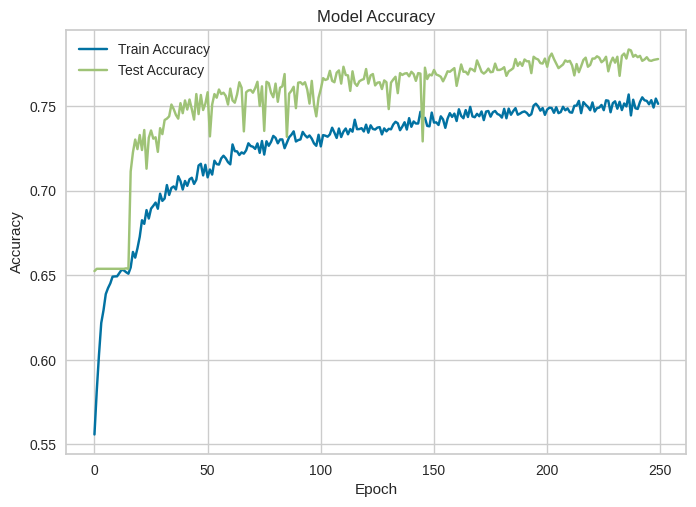

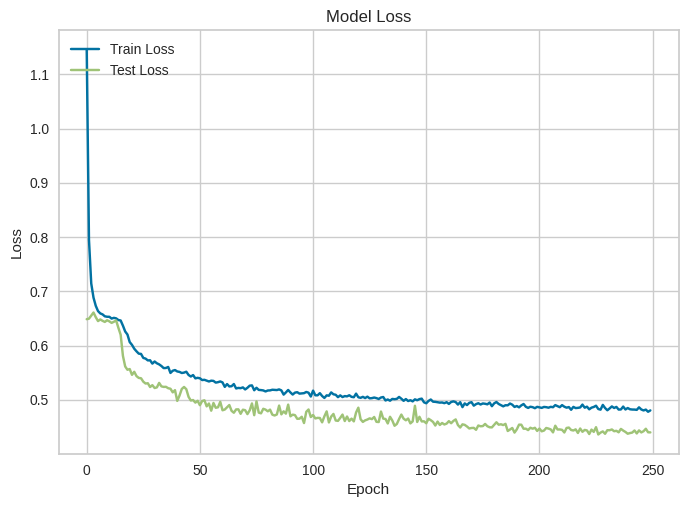

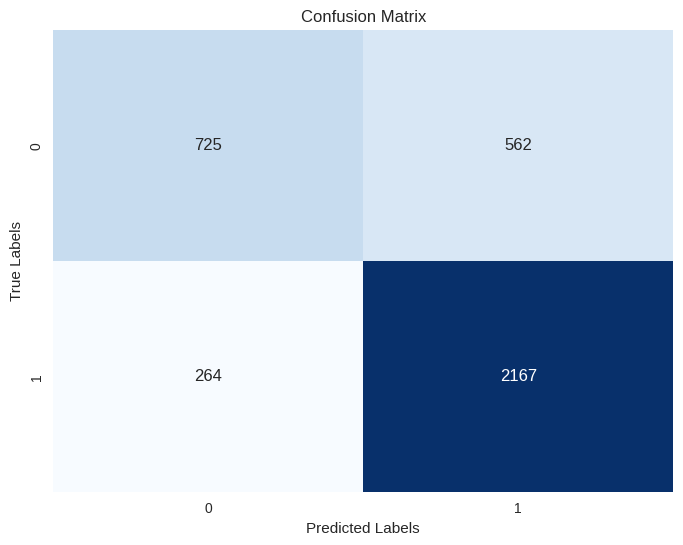

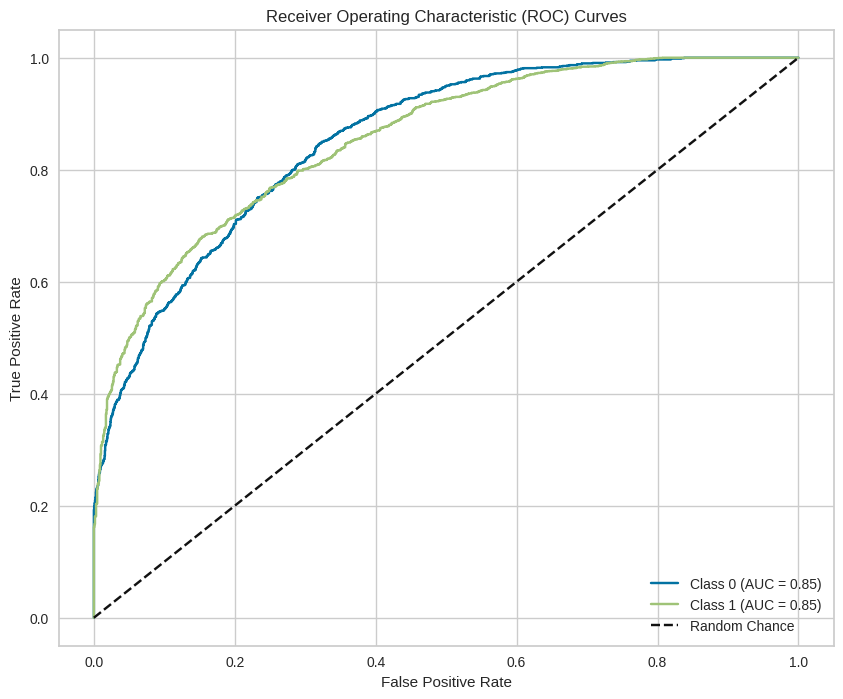

In [ ]:
evaluate_model(model, X_test, y_test, history)

##CNN 3: Más profunda

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

#Capa 1
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

#Capa 2
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)


#Capa 3
x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

#ANN
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - accuracy: 0.5308 - loss: 1.5813 - val_accuracy: 0.6538 - val_loss: 0.6567
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5782 - loss: 0.8067 - val_accuracy: 0.6538 - val_loss: 0.6505
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6097 - loss: 0.7010 - val_accuracy: 0.6538 - val_loss: 0.6451
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6233 - loss: 0.6795 - val_accuracy: 0.6538 - val_loss: 0.6478
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6286 - loss: 0.6713 - val_accuracy: 0.6538 - val_loss: 0.6442
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6429 - loss: 0.6603 - val_accuracy: 0.6538 - val_loss: 0.6451
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6421 - loss: 0.6620 - val_accuracy: 0.6538 - val_loss: 0.6457
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6414 - loss: 0.6604 - val_a

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.766003227541689
F1 Score: 0.8278591214879303
Recall: 0.8605512134923899


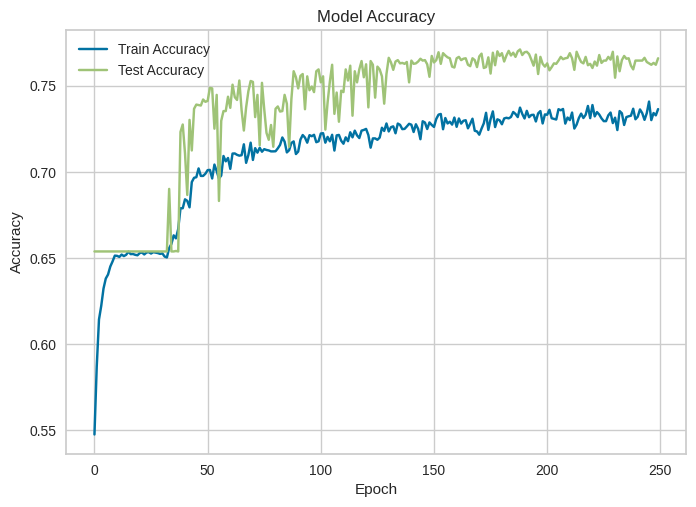

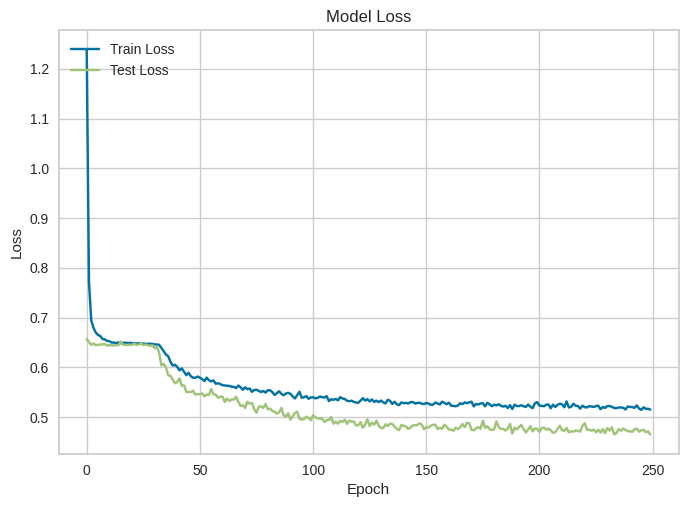

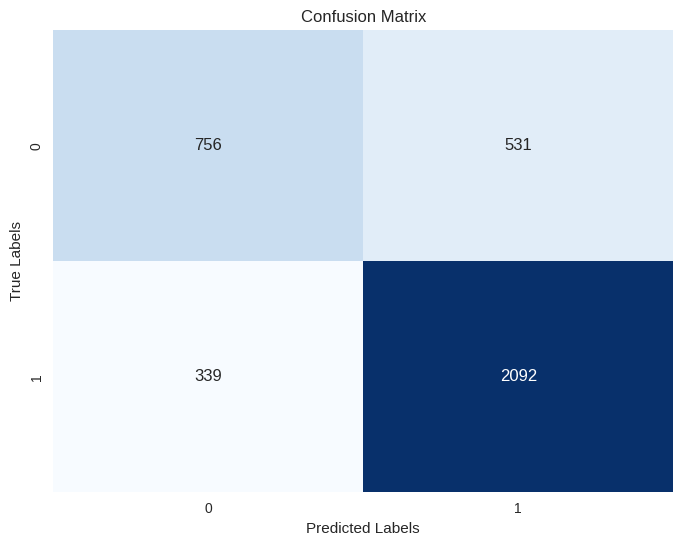

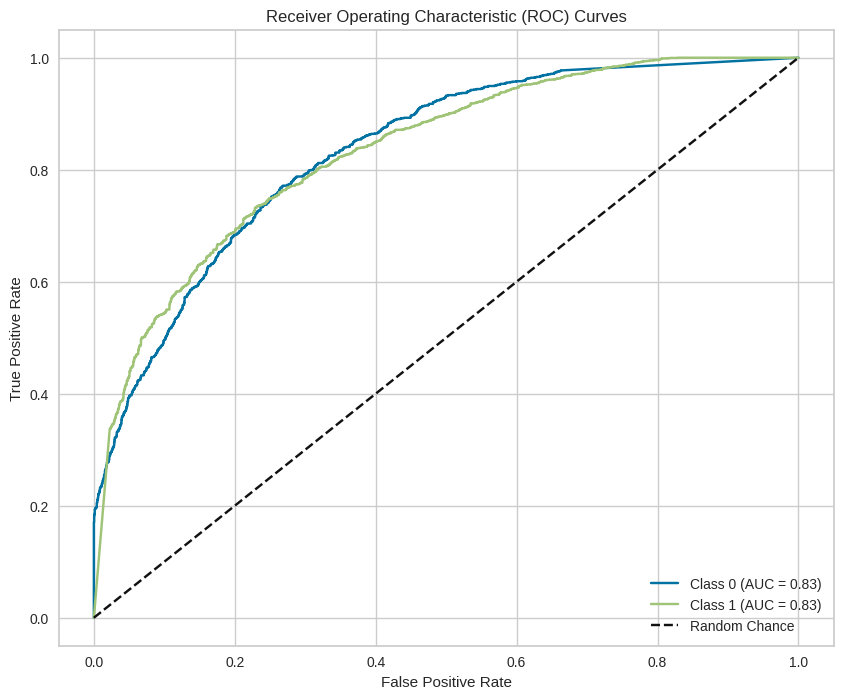

In [ ]:
evaluate_model(model, X_test, y_test, history)

##CNN: Intentando mejorar la mejor profunda con mas capas internas

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

#Capa 1
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

#Capa 2
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

x = tf.keras.layers.Flatten()(x)

# ANN
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 39s 230ms/step - accuracy: 0.5367 - loss: 1.5012 - val_accuracy: 0.3462 - val_loss: 0.8134
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5713 - loss: 0.7958 - val_accuracy: 0.6538 - val_loss: 0.6698
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6172 - loss: 0.6912 - val_accuracy: 0.6538 - val_loss: 0.6470
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6321 - loss: 0.6770 - val_accuracy: 0.6538 - val_loss: 0.6438
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6448 - loss: 0.6622 - val_accuracy: 0.6538 - val_loss: 0.6431
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6476 - loss: 0.6568 - val_accuracy: 0.6538 - val_loss: 0.6389
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6479 - loss: 0.6571 - val_accuracy: 0.6697 - val_loss: 0.6310
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6430 - loss: 0.6594 - val_a

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.7829478214093599
F1 Score: 0.8478219875542145
Recall: 0.9247223364870424


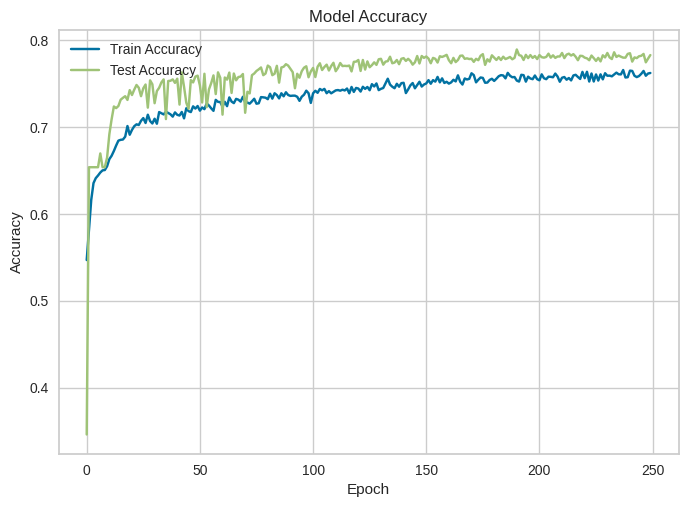

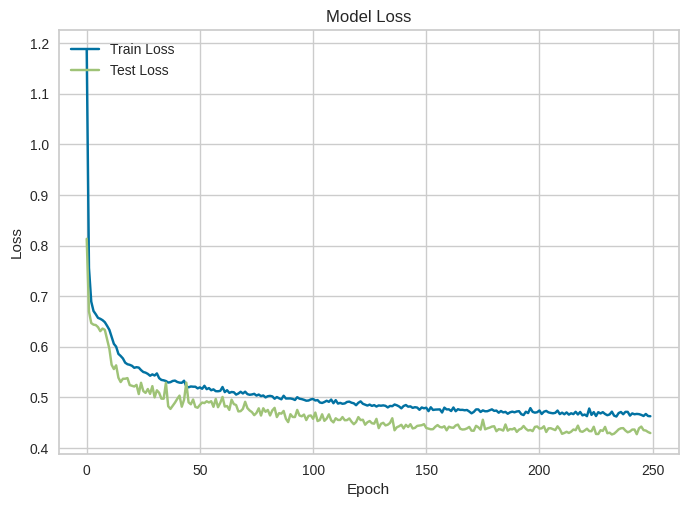

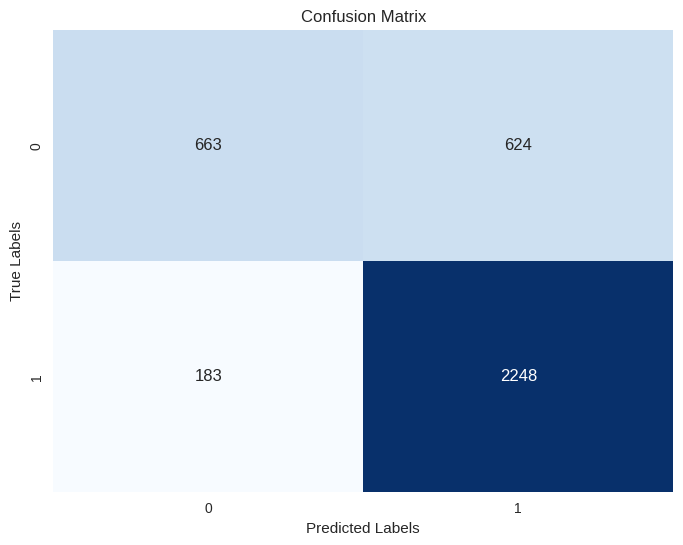

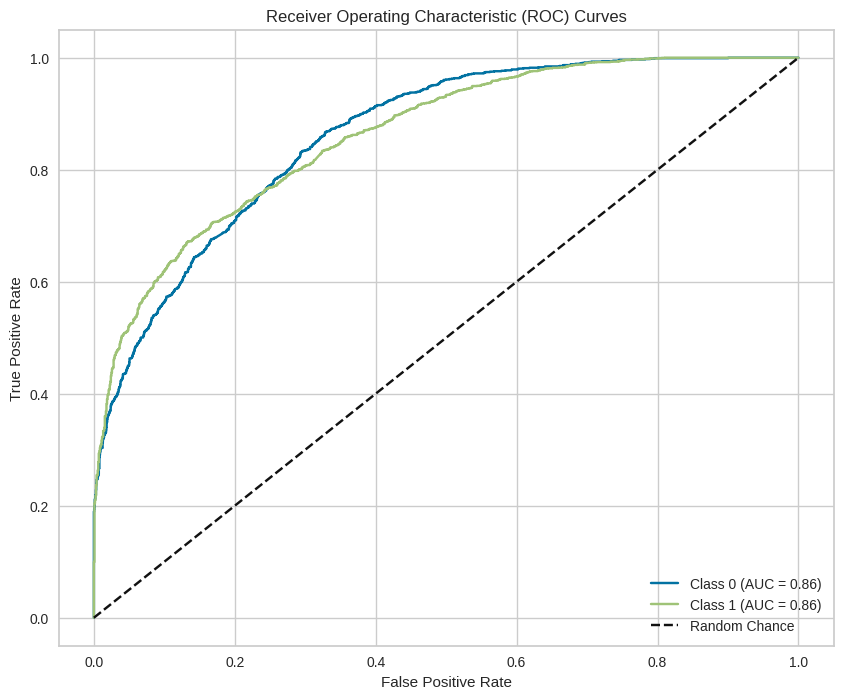

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Intentando mejorar la mejor CNN con más capas internas

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 0.5257 - loss: 1.5120 - val_accuracy: 0.6538 - val_loss: 0.8191
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5672 - loss: 0.7978 - val_accuracy: 0.6538 - val_loss: 0.6882
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5991 - loss: 0.7199 - val_accuracy: 0.6538 - val_loss: 0.6666
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6212 - loss: 0.6882 - val_accuracy: 0.6538 - val_loss: 0.6675
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6243 - loss: 0.6786 - val_accuracy: 0.6538 - val_loss: 0.6526
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6314 - loss: 0.6670 - val_accuracy: 0.6538 - val_loss: 0.6517
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6422 - loss: 0.6602 - val_accuracy: 0.6538 - val_loss: 0.6521
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6383 - loss: 0.6600 - val_a

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7883270575578268
F1 Score: 0.8451092304664437
Recall: 0.8831756478815302


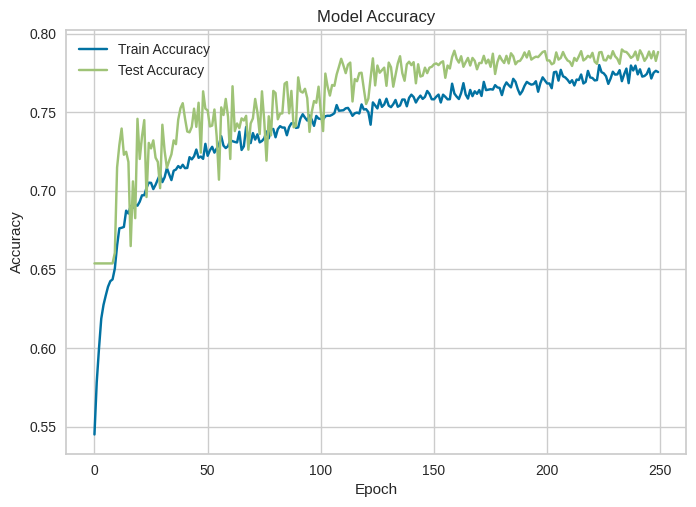

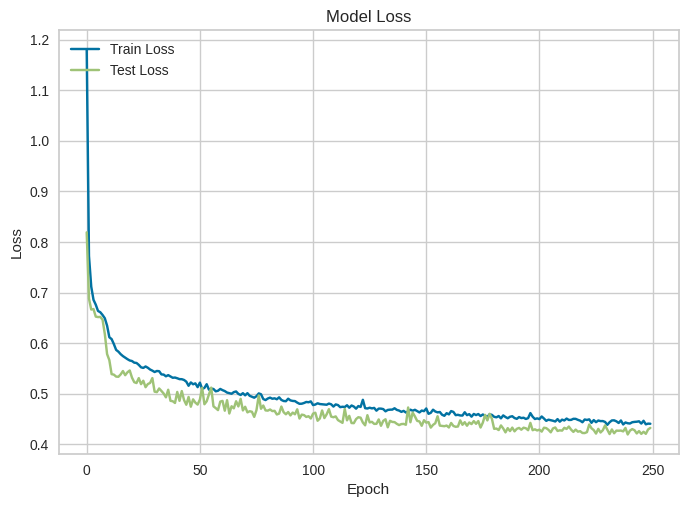

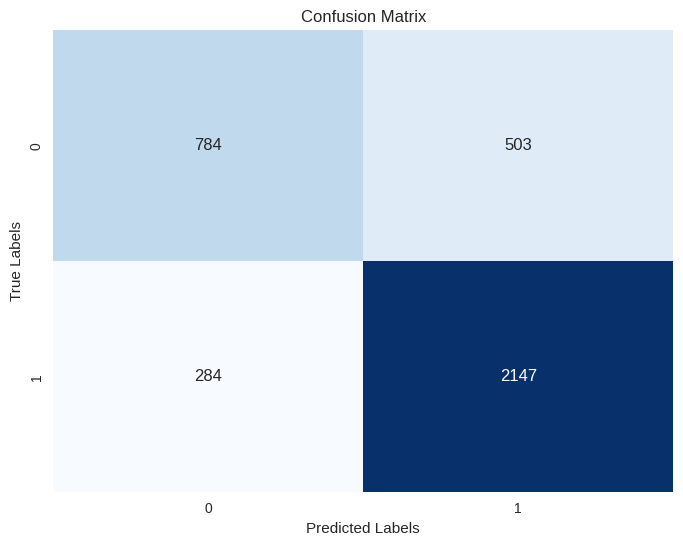

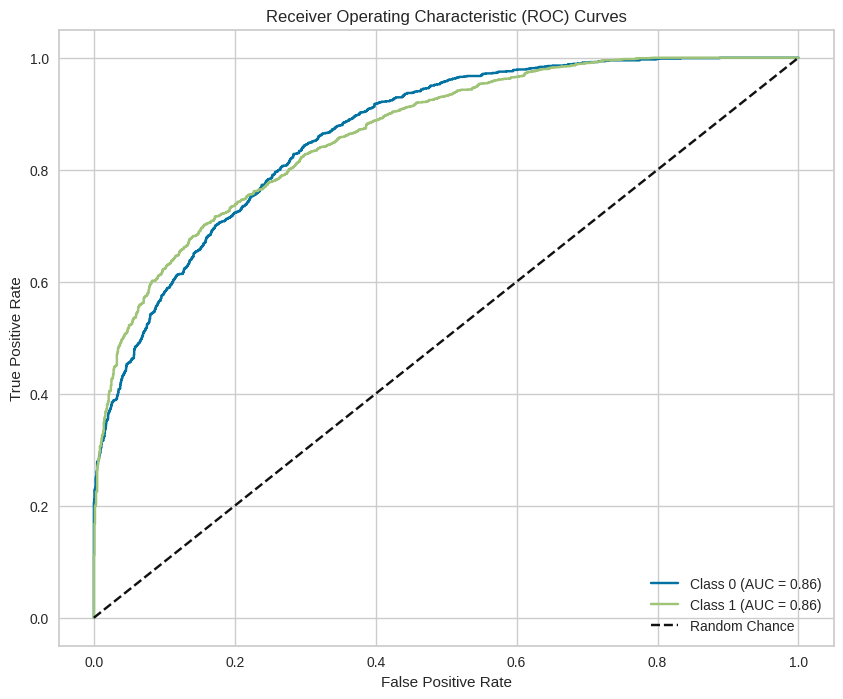

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Otra capa interna

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5725 - loss: 0.8544 - val_accuracy: 0.6538 - val_loss: 0.6858
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5869 - loss: 0.7341 - val_accuracy: 0.6538 - val_loss: 0.6678
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6091 - loss: 0.7011 - val_accuracy: 0.6538 - val_loss: 0.6534
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6093 - loss: 0.6879 - val_accuracy: 0.6538 - val_loss: 0.6709
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6241 - loss: 0.6783 - val_accuracy: 0.6538 - val_loss: 0.6635
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6338 - loss: 0.6657 - val_accuracy: 0.6538 - val_loss: 0.6501
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6320 - loss: 0.6643 - val_accuracy: 0.6538 - val_loss: 0.6480
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6354 - loss: 0.6542 - val_accu

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7910166756320602
F1 Score: 0.851063829787234
Recall: 0.9132044426162074


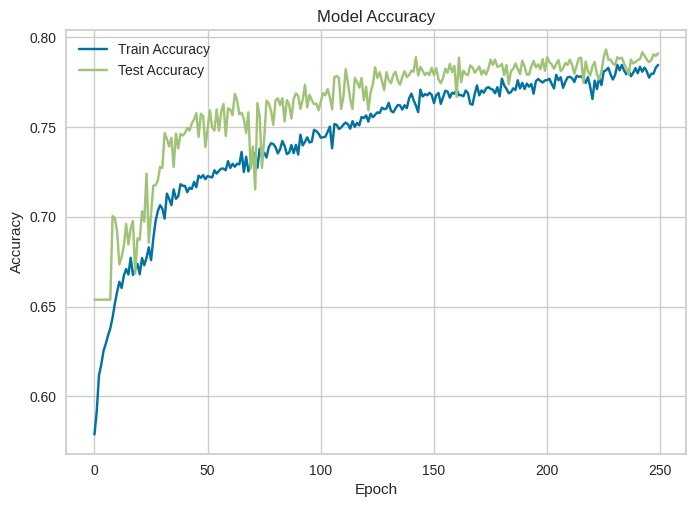

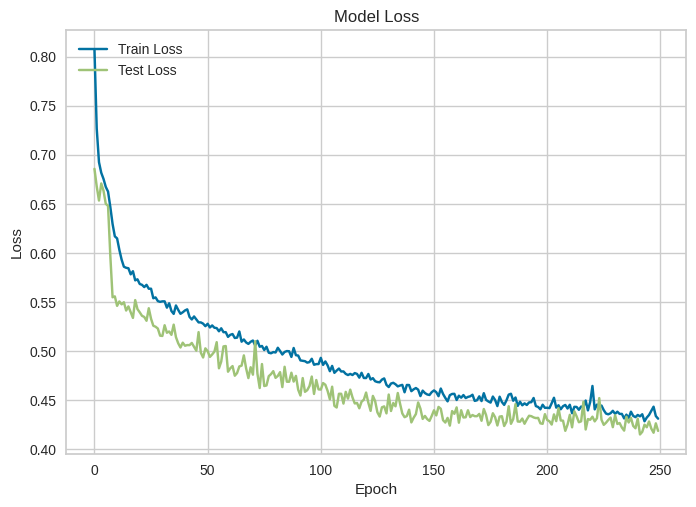

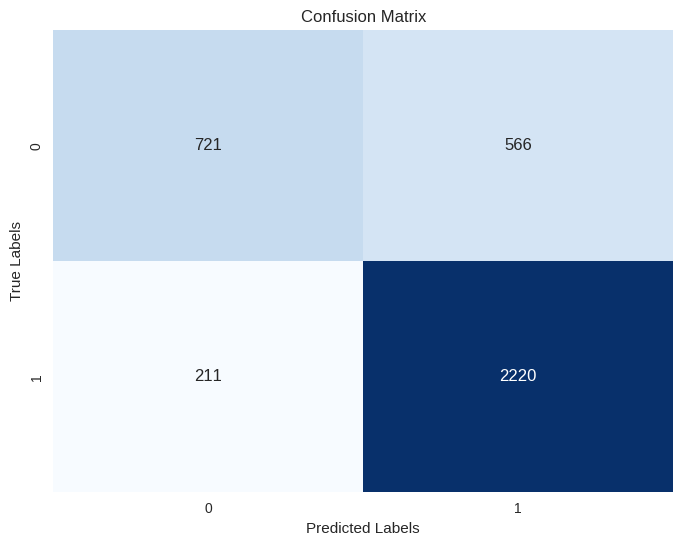

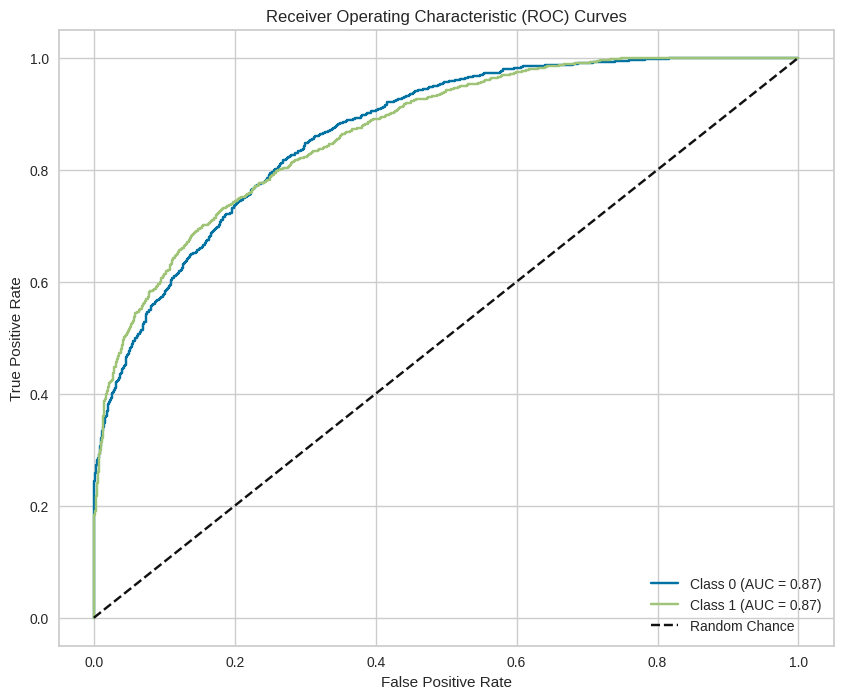

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Otra

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 49s 266ms/step - accuracy: 0.5282 - loss: 1.0442 - val_accuracy: 0.6538 - val_loss: 0.6571
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.6235 - loss: 0.6820 - val_accuracy: 0.6538 - val_loss: 0.6459
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6281 - loss: 0.6657 - val_accuracy: 0.6538 - val_loss: 0.6431
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6510 - loss: 0.6541 - val_accuracy: 0.6538 - val_loss: 0.6345
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6445 - loss: 0.6547 - val_accuracy: 0.6538 - val_loss: 0.6177
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6552 - loss: 0.6365 - val_accuracy: 0.6958 - val_loss: 0.5750
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6680 - loss: 0.6134 - val_accuracy: 0.7219 - val_loss: 0.5588
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6705 - loss: 0.6050 - val_

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7885960193652501
F1 Score: 0.8479690522243714
Recall: 0.9016865487453722


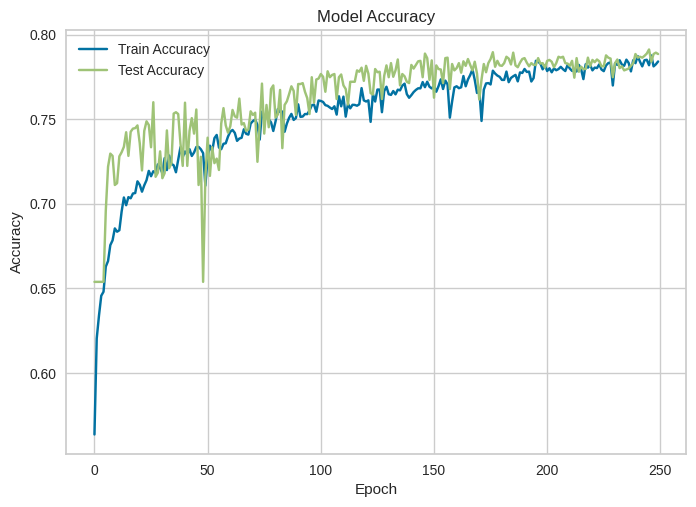

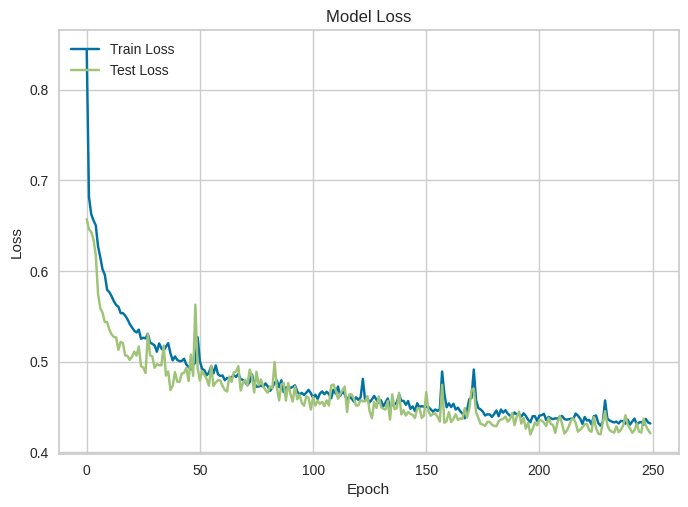

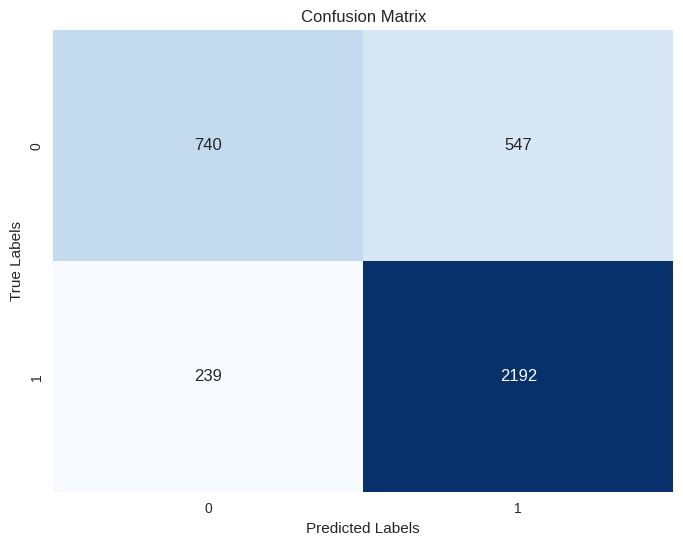

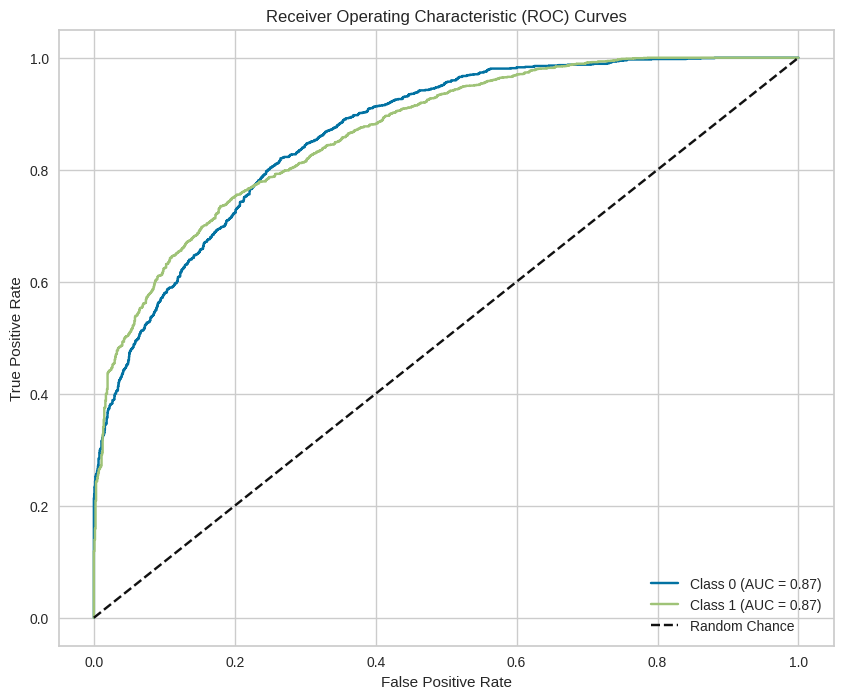

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Variando el kernel a la mejor CNN: K=5

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 73s 476ms/step - accuracy: 0.5277 - loss: 1.6763 - val_accuracy: 0.6538 - val_loss: 0.7398
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.5697 - loss: 0.8185 - val_accuracy: 0.6538 - val_loss: 0.6425
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6111 - loss: 0.7072 - val_accuracy: 0.6538 - val_loss: 0.6394
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6253 - loss: 0.6806 - val_accuracy: 0.6538 - val_loss: 0.6237
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6395 - loss: 0.6641 - val_accuracy: 0.6635 - val_loss: 0.6125
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6369 - loss: 0.6531 - val_accuracy: 0.7160 - val_loss: 0.5649
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6579 - loss: 0.6311 - val_accuracy: 0.6998 - val_loss: 0.5630
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6621 - loss: 0.6270 - val_

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7926304464766003
F1 Score: 0.8518731988472622
Recall: 0.9119703825586178


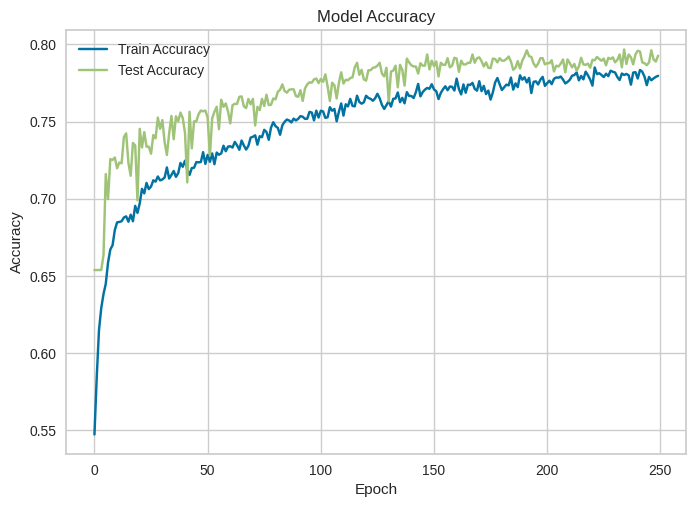

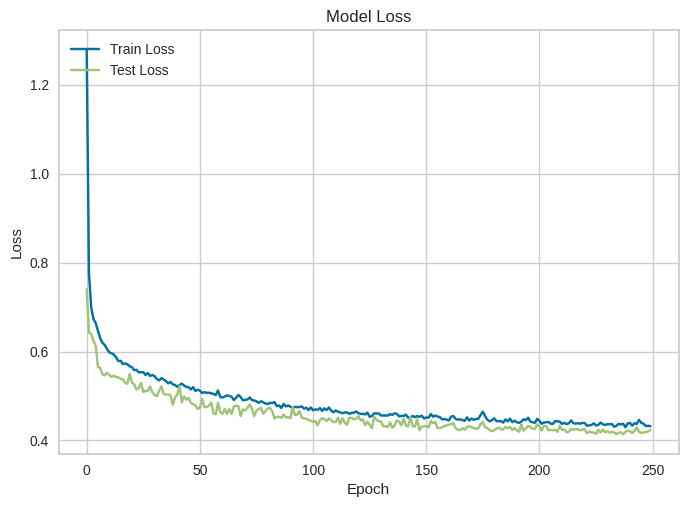

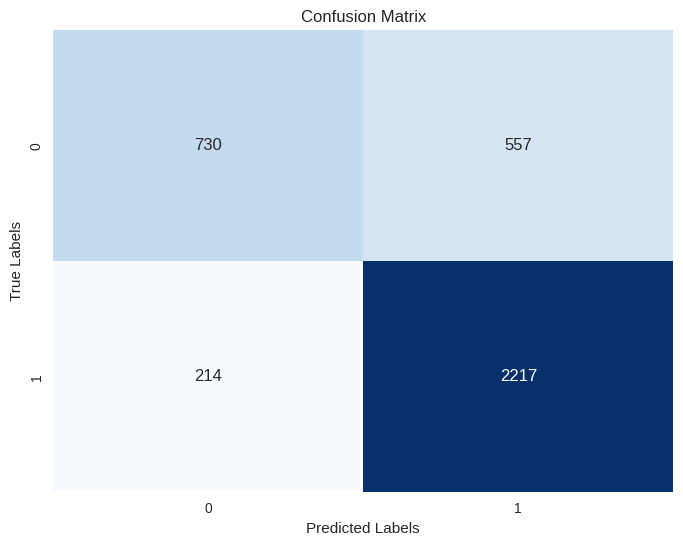

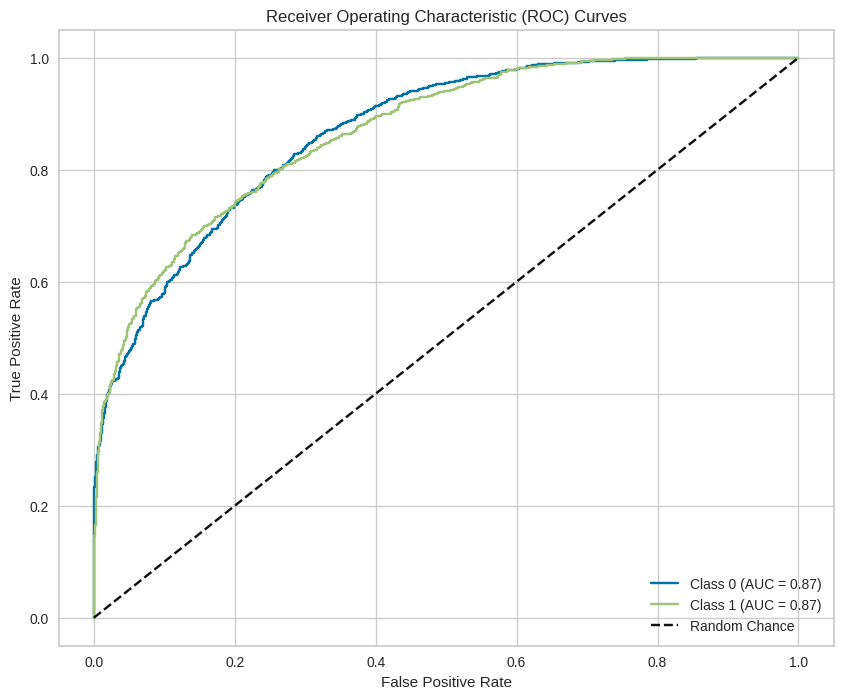

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Kernel =7

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 35s 224ms/step - accuracy: 0.5412 - loss: 2.2814 - val_accuracy: 0.4545 - val_loss: 0.7014
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5745 - loss: 0.9107 - val_accuracy: 0.5584 - val_loss: 0.6894
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5894 - loss: 0.7624 - val_accuracy: 0.6538 - val_loss: 0.6721
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6114 - loss: 0.7148 - val_accuracy: 0.6538 - val_loss: 0.6657
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6257 - loss: 0.6840 - val_accuracy: 0.6538 - val_loss: 0.6520
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6381 - loss: 0.6653 - val_accuracy: 0.6538 - val_loss: 0.6496
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6436 - loss: 0.6600 - val_accuracy: 0.6538 - val_loss: 0.6422
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6536 - loss: 0.6502 - val_a

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.7859064012910166
F1 Score: 0.8442879499217527
Recall: 0.8877005347593583


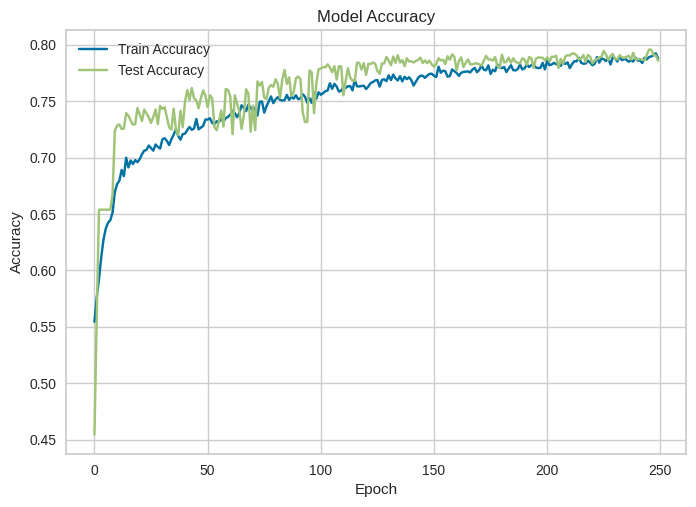

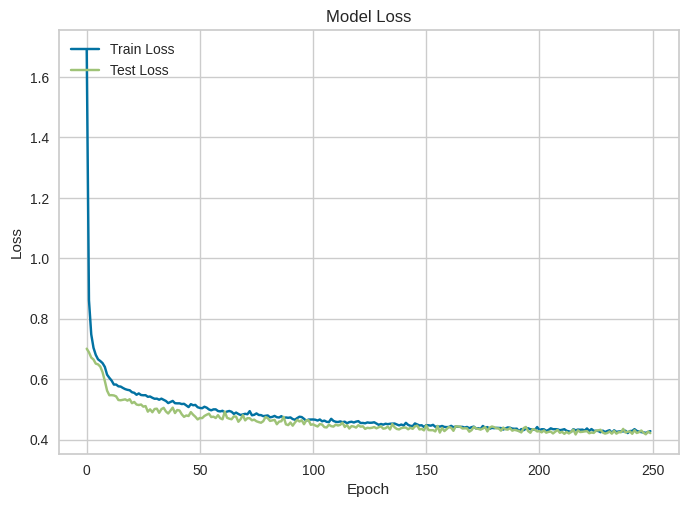

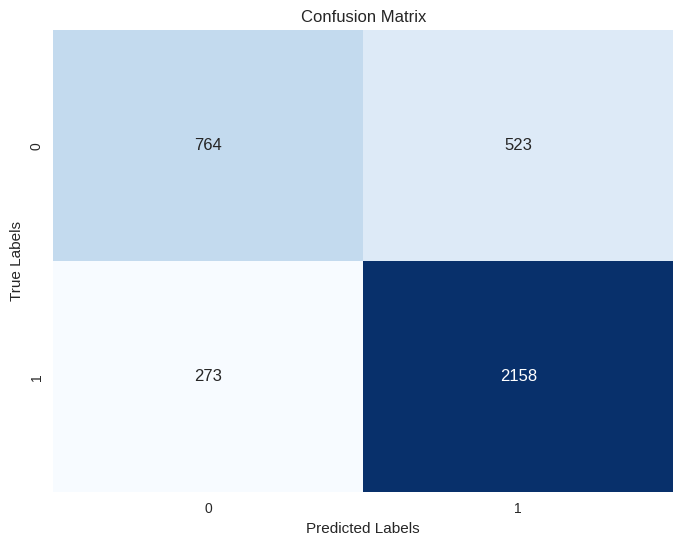

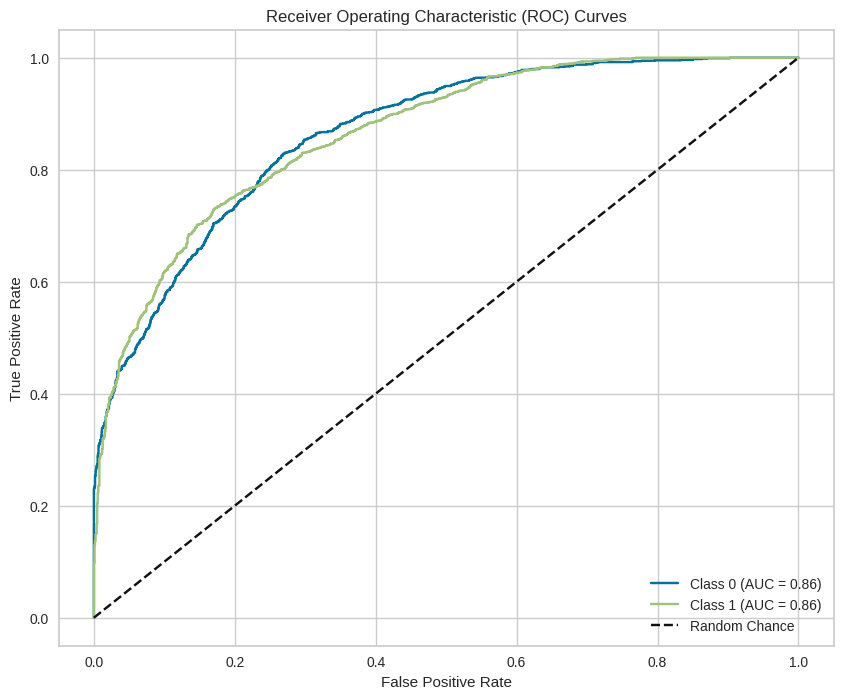

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Mejorando la red anterior

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)


#Capa 2
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

x = tf.keras.layers.Flatten()(x)


# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 44s 199ms/step - accuracy: 0.5332 - loss: 1.3958 - val_accuracy: 0.6538 - val_loss: 0.6553
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5841 - loss: 0.7450 - val_accuracy: 0.6538 - val_loss: 0.6488
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6205 - loss: 0.6849 - val_accuracy: 0.6538 - val_loss: 0.6452
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6357 - loss: 0.6670 - val_accuracy: 0.6538 - val_loss: 0.6465
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6379 - loss: 0.6599 - val_accuracy: 0.6538 - val_loss: 0.6462
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6415 - loss: 0.6591 - val_accuracy: 0.6538 - val_loss: 0.6456
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6426 - loss: 0.6585 - val_accuracy: 0.6538 - val_loss: 0.6508
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6454 - loss: 0.6545 - val_a

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.7694997310381926
F1 Score: 0.8253515386183004
Recall: 0.8329905388728918


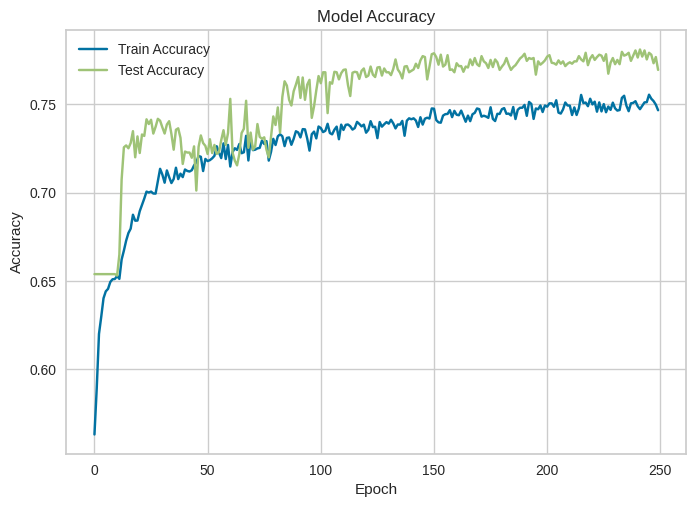

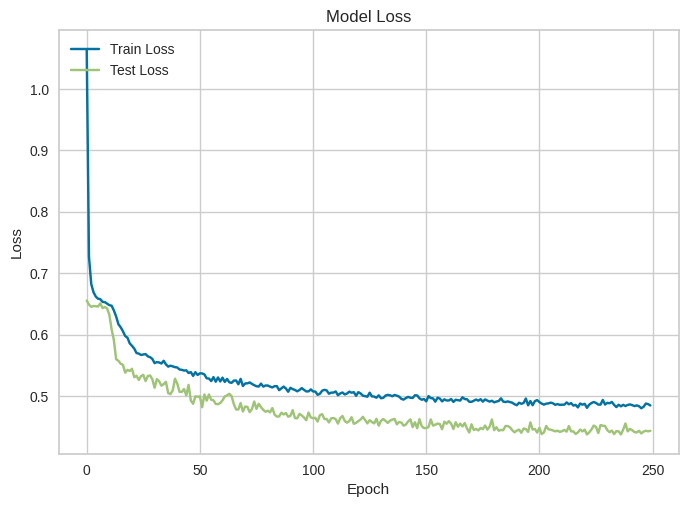

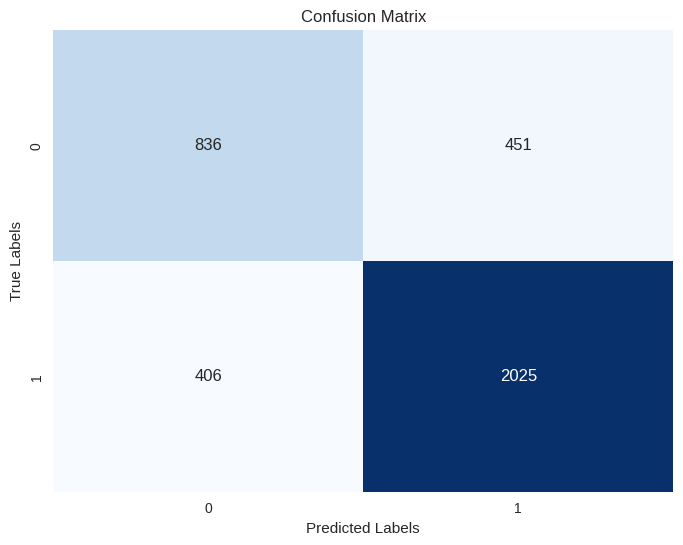

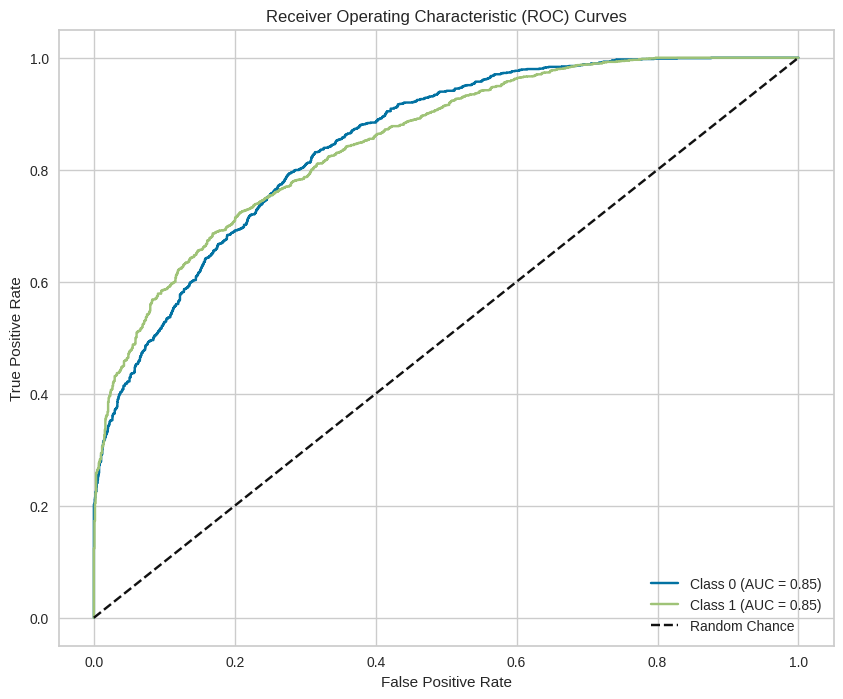

In [ ]:
evaluate_model(model, X_test, y_test, history)

In [ ]:
import numpy as np
# Matriz de confusión
confusion_matrix_values = np.array([
    [836, 451],
    [406, 2025]
])

# Calcular la matriz de confusión en porcentaje por filas
conf_matrix_percent = confusion_matrix_values.astype('float') / confusion_matrix_values.sum(axis=1)[:, np.newaxis] * 100

# Mostrar la matriz en porcentajes
print(conf_matrix_percent)

[[64.95726496 35.04273504]
 [16.70094611 83.29905389]]


##Otra

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)


#Capa 2
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

x = tf.keras.layers.Flatten()(x)


# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.5393 - loss: 1.4240 - val_accuracy: 0.6541 - val_loss: 0.6477
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5782 - loss: 0.7820 - val_accuracy: 0.6538 - val_loss: 0.6443
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6190 - loss: 0.6899 - val_accuracy: 0.6538 - val_loss: 0.6457
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6260 - loss: 0.6825 - val_accuracy: 0.6538 - val_loss: 0.6433
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6420 - loss: 0.6687 - val_accuracy: 0.6538 - val_loss: 0.6445
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6441 - loss: 0.6637 - val_accuracy: 0.6538 - val_loss: 0.6462
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6509 - loss: 0.6548 - val_accuracy: 0.6538 - val_loss: 0.6465
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6489 - loss: 0.6553 - val_a

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7786444324905863
F1 Score: 0.8430886558627264
Recall: 0.9095022624434389


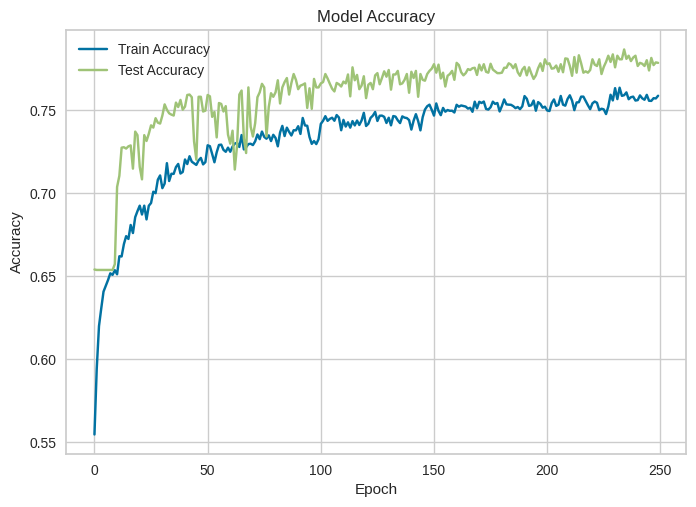

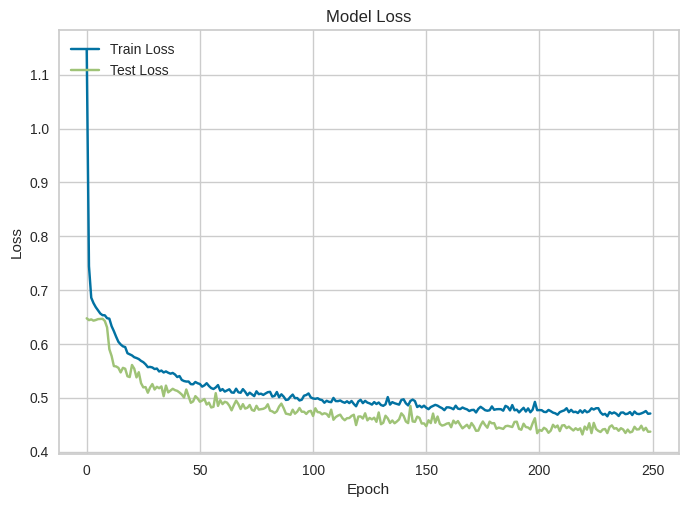

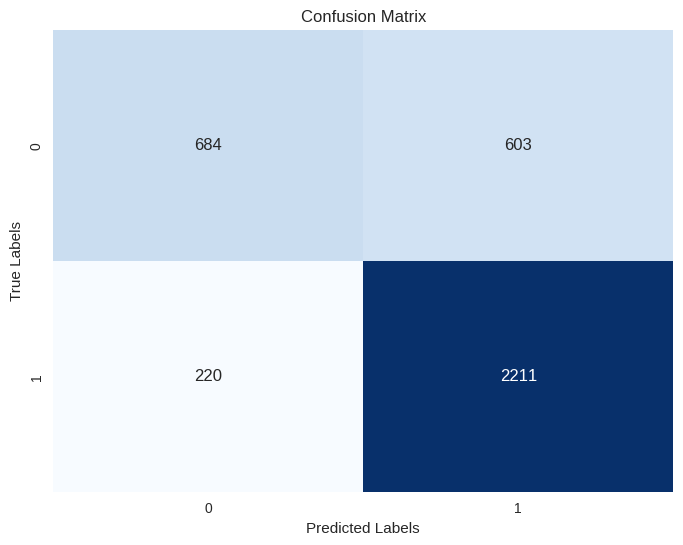

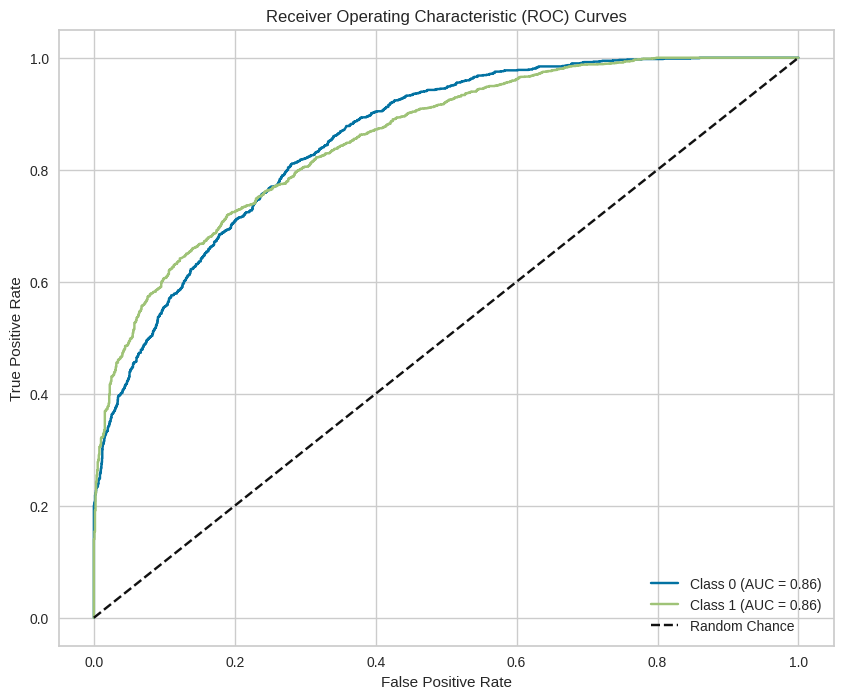

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Ultima red

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)


#Capa 2
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)


#Capa 3
x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.5452 - loss: 1.0943 - val_accuracy: 0.6458 - val_loss: 0.6680
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.7032 - val_accuracy: 0.6538 - val_loss: 0.6562
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6338 - loss: 0.6670 - val_accuracy: 0.6538 - val_loss: 0.6499
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6337 - loss: 0.6680 - val_accuracy: 0.6538 - val_loss: 0.6458
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6459 - loss: 0.6548 - val_accuracy: 0.6538 - val_loss: 0.6450
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6529 - loss: 0.6527 - val_accuracy: 0.6538 - val_loss: 0.6435
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6521 - loss: 0.6516 - val_accuracy: 0.6538 - val_loss: 0.6436
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6515 - loss: 0.6493 - val_a

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.7665411511565358
F1 Score: 0.8301369863013698
Recall: 0.8724804607157548


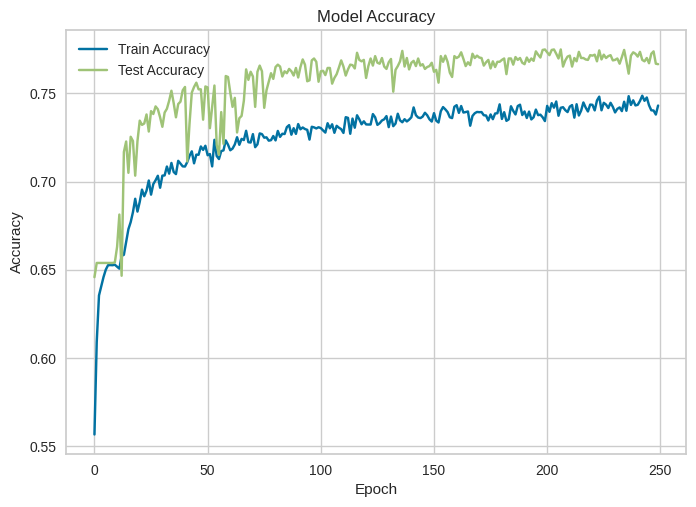

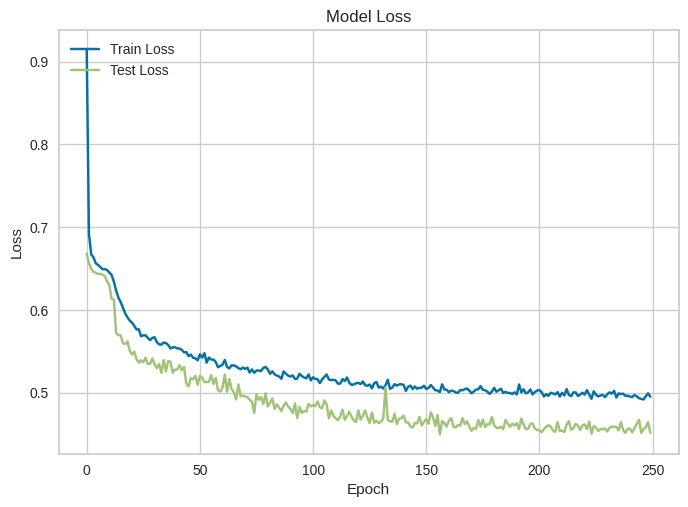

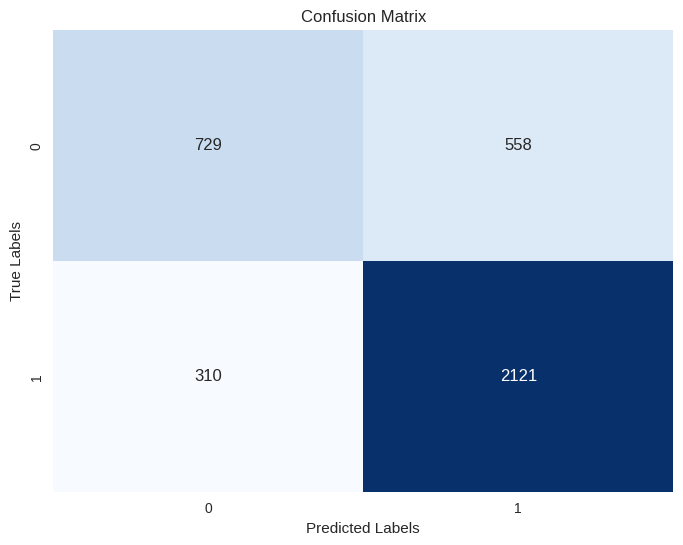

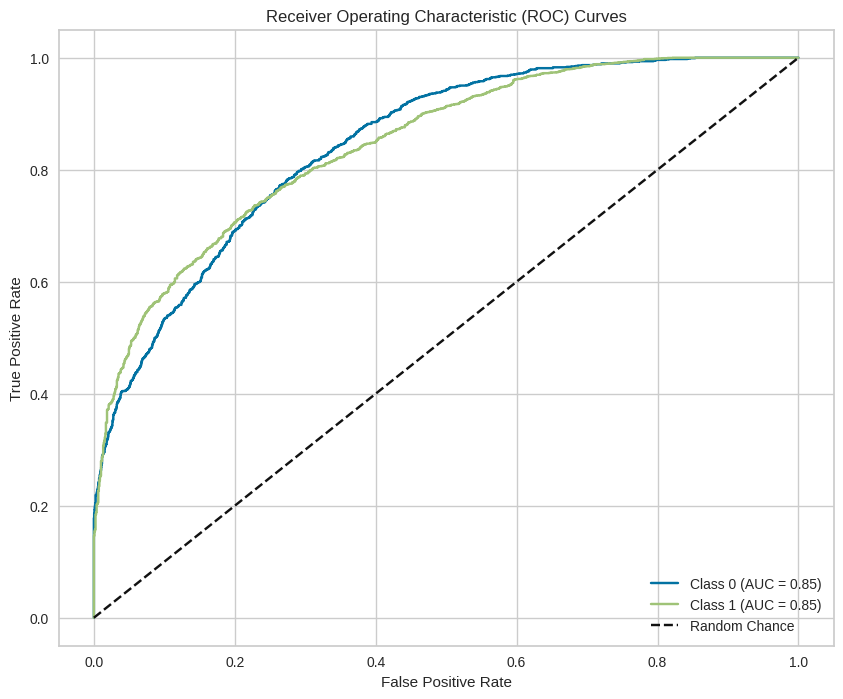

In [ ]:
evaluate_model(model, X_test, y_test, history)

##MEJOR RED CNN

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)


#Capa 2
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('selu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

x = tf.keras.layers.Flatten()(x)


# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='selu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='selu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

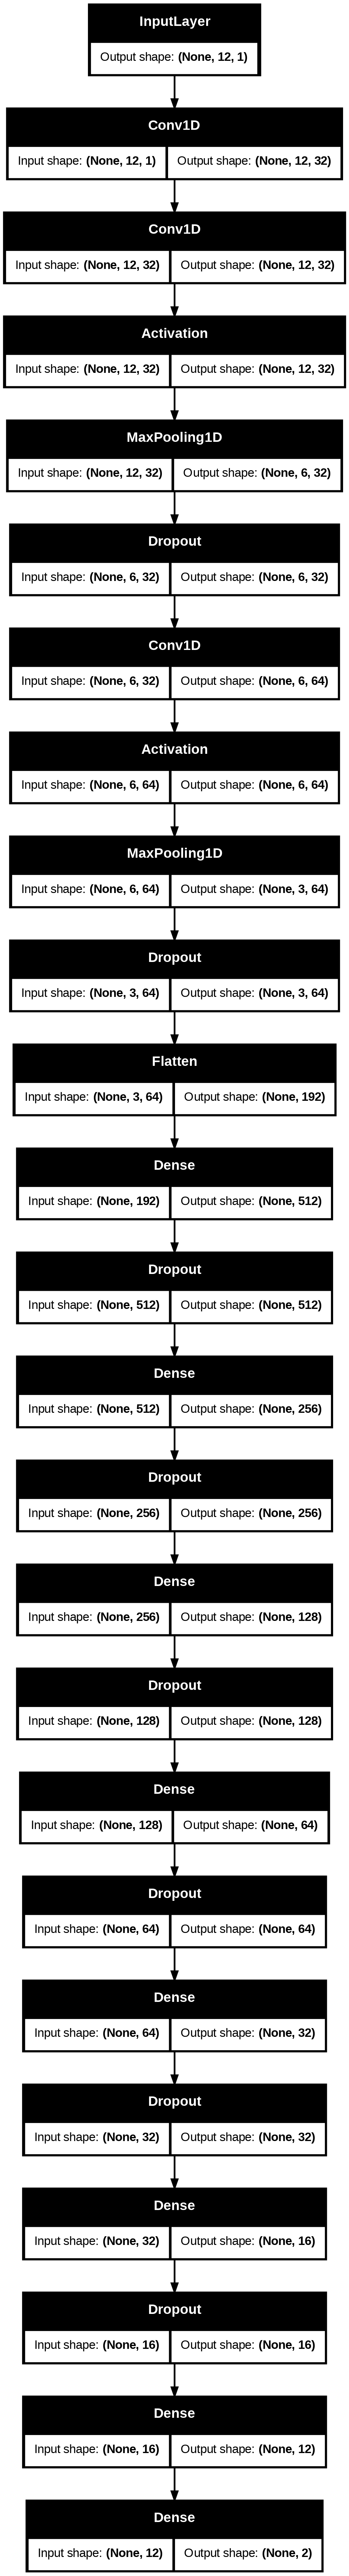

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)